In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip uninstall -y shap tensorflow keras
!pip install tensorflow==2.12.0 keras==2.12.0 shap==0.44.1 --quiet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input/hms-harmful-brain-activity-classification'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.8/535.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 21.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, 

/tmp/ipykernel_93/652326744.py:51: RuntimeWarning: invalid value encountered in log1p
  data = np.log1p(data)
/tmp/ipykernel_93/652326744.py:53: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)


Epoch 1/10
110/110 [==============================] - 180s 2s/step - loss: 1.7461 - accuracy: 0.2303 - val_loss: 1.6529 - val_accuracy: 0.3213
Epoch 2/10
110/110 [==============================] - 200s 2s/step - loss: 1.6128 - accuracy: 0.4029 - val_loss: 1.5281 - val_accuracy: 0.5480
Epoch 3/10
110/110 [==============================] - 185s 2s/step - loss: 1.4682 - accuracy: 0.6194 - val_loss: 1.3425 - val_accuracy: 0.7440
Epoch 4/10
110/110 [==============================] - 179s 2s/step - loss: 1.2395 - accuracy: 0.7420 - val_loss: 1.0914 - val_accuracy: 0.8027
Epoch 5/10
110/110 [==============================] - 179s 2s/step - loss: 0.9742 - accuracy: 0.8000 - val_loss: 0.7959 - val_accuracy: 0.8333
Epoch 6/10
110/110 [==============================] - 181s 2s/step - loss: 0.7207 - accuracy: 0.8517 - val_loss: 0.5873 - val_accuracy: 0.8547
Epoch 7/10
110/110 [==============================] - 181s 2s/step - loss: 0.5453 - accuracy: 0.8800 - val_loss: 0.4488 - val_accuracy: 0.9053

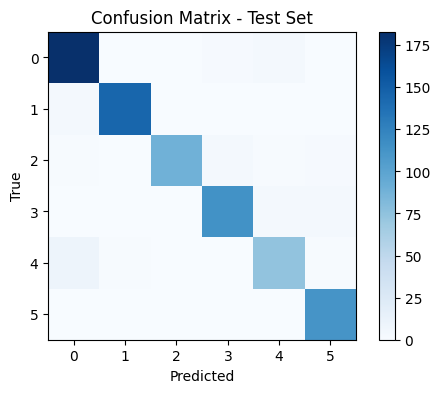

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import pyarrow.parquet as pq
import io
import scipy.signal
from PIL import Image

# Define dataset directories
data_csv = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
parquet_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms"

# Load metadata
df = pd.read_csv(data_csv)

# Filter rows that have corresponding parquet files
existing_files = set(os.listdir(parquet_dir))
df = df[df["spectrogram_id"].apply(lambda x: f"{x}.parquet" in existing_files)]

# Limit to first 5000 samples
df = df.head(5000)

if df.empty:
    raise ValueError("No matching parquet files found. Check your directory and filenames.")

# Encode labels
y = df["expert_consensus"].dropna()
df = df.loc[y.index]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Metadata features
X_meta = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(X_meta)

# Helper to convert spectrogram parquet to image array
def load_spectrogram_as_image(spectrogram_id, size=(224, 224)):
    file_path = os.path.join(parquet_dir, f"{spectrogram_id}.parquet")
    table = pq.read_table(file_path)
    data = table.to_pandas().values.T  # Transpose to get (freq, time)
    data = np.log1p(data)
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    img = Image.fromarray(np.uint8(data * 255)).convert("RGB").resize(size)
    return np.array(img) / 255.0

# Load spectrogram images
X_images = np.stack([load_spectrogram_as_image(sid) for sid in df["spectrogram_id"]])

# Split dataset
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_images, X_meta, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define RetNet-inspired image model 
from tensorflow.keras.applications import ResNet50

image_input = keras.Input(shape=(224, 224, 3), name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
image_features = layers.Dropout(0.3)(x)

# Metadata model
meta_input = keras.Input(shape=(X_meta.shape[1],), name="meta_input")
y_meta = layers.Dense(32, activation='relu')(meta_input)
meta_features = layers.Dense(16, activation='relu')(y_meta)

# Merge models
merged = layers.concatenate([image_features, meta_features])
z = layers.Dense(64, activation='relu')(merged)
out = layers.Dense(y_categorical.shape[1], activation='softmax')(z)

model = keras.Model(inputs=[image_input, meta_input], outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(
    x=[X_img_train, X_meta_train],
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_img_val, X_meta_val], y_val)
)

# Evaluate model
y_pred = model.predict([X_img_test, X_meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Test Report:\n", classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix(y_true_classes, y_pred_classes), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
!pip install lime --quiet

from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

# Select a test image index
idx = random.randint(0, len(X_img_test) - 1)
test_img = X_img_test[idx]
true_label = np.argmax(y_test[idx])
print(f"Explaining Test Sample Index: {idx}, True Class: {true_label}")

# LIME expects batch input to model, so define a wrapper for image input only
def predict_fn(images):
    images = tf.image.resize(images, (224, 224))  # Ensure size
    metas = np.tile(X_meta_test[idx], (images.shape[0], 1))  # Repeat metadata
    return model.predict([images, metas])

# Create LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Run explanation
explanation = explainer.explain_instance(
    image=test_img,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get image + mask
from skimage.color import label2rgb

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Plot explanation
plt.figure(figsize=(6, 6))
plt.title(f"LIME Explanation for Class: {explanation.top_labels[0]}")
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 81.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.3.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatib

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


In [27]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Build image-only submodel manually (reuse CNN layers)
image_input = tf.keras.Input(shape=(224, 224, 3), name="image_input")
x = model.get_layer("conv2d_3")(image_input)
x = model.get_layer("max_pooling2d_2")(x)
x = model.get_layer("conv2d_4")(x)
x = model.get_layer("max_pooling2d_3")(x)
x = model.get_layer("conv2d_5")(x)
x = model.get_layer("global_average_pooling2d_1")(x)
x = model.get_layer("dense_5")(x)
x = model.get_layer("dropout_1")(x)

# Image feature extractor model
image_only_model = tf.keras.Model(inputs=image_input, outputs=x)

# Step 2: Prepare background + test image
background = X_img_train[np.random.choice(X_img_train.shape[0], 50, replace=False)]
test_image = X_img_test[0:1]

# Step 3: SHAP GradientExplainer
explainer = shap.GradientExplainer(image_only_model, background)

# Step 4: Compute SHAP values
shap_values = explainer.shap_values(test_image)

# Step 5: Visualize SHAP explanation
shap.image_plot(shap_values, test_image)

AttributeError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_gradient.py", line 218, in grad_graph  *
        tf.keras.backend.set_learning_phase(0)

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'set_learning_phase'
